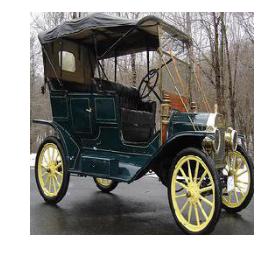

crop_0
0 0
0 16
0 32
0 48
16 0
16 16
16 32
16 48
32 0
32 16
32 32
32 48
48 0
48 16
48 32
48 48
every_all
0 0
0 16
0 32
0 48
16 0
16 16
16 32
16 48
32 0
32 16
32 32
32 48
48 0
48 16
48 32
48 48
done


In [69]:
from constant import *
import os
import caffe
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageColor
import copy
import IPython.display

filename = '/home/haow3/software/interesting/deepdream/modelT.jpg'
class_id = 65
models = ['crop_0', 'every_all']

aperture_size = 0.2
step = 64

caffe.set_device(1)
caffe.set_mode_gpu()

nets = {}

for model in models:
    nets[model] = caffe.Net(result_root + 'model/finetune_alexnet_{}/deploy.prototxt'.format(model),
                    result_root + 'model/finetune_alexnet_{}/finetune_alexnet_{}.caffemodel'.format(model, model),
                    caffe.TEST)

transformer = caffe.io.Transformer({'data': nets[nets.keys()[0]].blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB


img = Image.open(filename)
img = img.resize((256, 256))    
plt.axis("off")
plt.imshow(np.asarray(img))
plt.show()

interval = 256 * (1 - aperture_size) / step
length = int(256 * aperture_size)
mean_color = (123, 117, 104)

heat_map = {}
for model in models:
    print model
    heat_map[model] = np.zeros((step, step))
    count = 0
    for i in range(step):
        for j in range(step):
            occluded_img = copy.copy(img)
            subrect = [0, 0, 0, 0]
            subrect[0] = interval * i
            subrect[1] = interval * j
            subrect[2] = subrect[0] + length
            subrect[3] = subrect[1] + length


            d = ImageDraw.Draw(occluded_img)
            d.rectangle([0, 0, occluded_img.size[0], subrect[1]], fill=mean_color, outline=None)
            d.rectangle([0, 0, subrect[0], occluded_img.size[1]], fill=mean_color, outline=None)
            d.rectangle([subrect[2], 0, occluded_img.size[0], occluded_img.size[1]], fill=mean_color, outline=None)
            d.rectangle([0, subrect[3], occluded_img.size[0], occluded_img.size[1]], fill=mean_color, outline=None)

            occluded_img.save(filename + 'temp.jpg')

            nets[model].blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(filename + 'temp.jpg'))
            nets[model].forward()
            heat_map[model][i][j] = nets[model].blobs['prob'].data[0][class_id]

            if (i % 16 == 0 and j % 16 == 0):
                print i, j
                #plt.axis("off")
                #plt.imshow(np.asarray(occluded_img))
                #plt.show()

print 'done'

crop_0


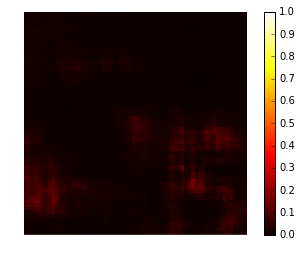

every_all


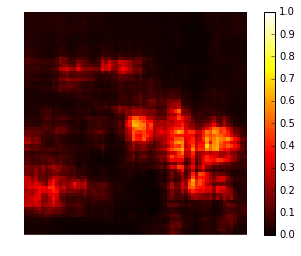

In [71]:
for model in models:
    print model  
    plt.axis("off")
    plt.imshow(np.swapaxes(heat_map[model],0,1) , cmap='hot', interpolation='none', vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

In [ ]:
for model in models:
    plt.pcolor(x, y, z, cmap='hot', vmin=0, vmax=1)
    plt.colorbar()